# Project 3

Store Analysis

**Problem Statement**

Which counties are the top ten in terms of retail sales to consumers (not wholesalers) over the course of a year? How do they 

### Import Packages

In [1]:
# Import Packages

# Functional Libraries
import numpy as np
import pandas as pd
import re
import patsy

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns


# Math Libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf


# Modeling Libraries
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

In [2]:
liquor = pd.read_csv('../../../Iowa_Liquor_Sales_reduced.csv') # Read in CSV

/Users/sebozek/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
liquor.shape                                                   # Determine shape of the matrix

(2709552, 18)

## Exploratory Analysis

*Look to clean up data, and run initial tests*

In [4]:
columns = liquor.columns.values      # Pull columns

In [5]:
new_cols = []                        # Create new list for assignment
for column in columns:
    col = re.sub('\s+', '_', column) # Replace spaces with Underscores
    col = re.sub('[()]','',col)      # Replace paren with emptyspace
    new_cols.append(col)             # Add to columns list

In [6]:
liquor.columns = new_cols            # Assign Current Columns to New Name

In [7]:
liquor.head()                        # Look at head of the dataframe

,Date,Store_Number,City,Zip_Code,County_Number,County,Category,Category_Name,Vendor_Number,Item_Number,Item_Description,Bottle_Volume_ml,State_Bottle_Cost,State_Bottle_Retail,Bottles_Sold,Sale_Dollars,Volume_Sold_Liters,Volume_Sold_Gallons
0,03/31/2016,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,370,87152,Avion Silver,375,$9.99,$14.99,12,$179.88,4.5,1.19
1,03/31/2016,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,395,89197,Jose Cuervo Especial Reposado Tequila,1000,$12.50,$18.75,2,$37.50,2.0,0.53
2,03/31/2016,4959,CEDAR FALLS,50613,7.0,Black Hawk,1071100.0,AMERICAN COCKTAILS,380,63959,Uv Blue Raspberry Lemonade Pet,1750,$5.97,$8.96,6,$53.76,10.5,2.77
3,03/31/2016,2190,DES MOINES,50314,77.0,Polk,1031200.0,VODKA FLAVORED,205,40597,New Amsterdam Red Berry,200,$2.24,$3.36,48,$161.28,9.6,2.54
4,03/31/2016,5240,WEST BRANCH,52358,NaN,NaN,1081200.0,CREAM LIQUEURS,305,73055,Rumchata,750,$12.50,$18.75,6,$112.50,4.5,1.19


In [8]:
dollar_columns = ['State_Bottle_Cost',      # Pull cols with dollar values
                  'State_Bottle_Retail', 
                  'Sale_Dollars']

liquor[dollar_columns] = \
liquor[dollar_columns].replace(             # Replace:
    '[\$,]',                                # Dollar signs with:
    "",regex=True                           # Empty Space and
).astype(float)                             # Assign to float

In [9]:
liquor.dtypes # assess conversion

Date                    object
Store_Number             int64
City                    object
Zip_Code                object
County_Number          float64
County                  object
Category               float64
Category_Name           object
Vendor_Number            int64
Item_Number              int64
Item_Description        object
Bottle_Volume_ml         int64
State_Bottle_Cost      float64
State_Bottle_Retail    float64
Bottles_Sold             int64
Sale_Dollars           float64
Volume_Sold_Liters     float64
Volume_Sold_Gallons    float64
dtype: object

*Will be focusing on a County level of sales to determine what counties are worth focusing on. Because of that will be creating new dataframe that contains truncated list. 
Need to also turn date into a datetime object."*

# Data Dictionary

|Name|Description|Variable Type|
|--|--|--|
|Date|Date The Transaction Took Place|Ordinal|
|Store_Number|Unique Numerical ID for Liquor Stores in Iowa|Ordinal|
|City|City Where Store is Based|Categorical|
|Zip_Code|Zip Code of Store Location|Ordinal|
|County_Number|The County's Number as Assigned by the State of Iowa|Ordinal|
|County|County Name|Categorical|
|Category|Unique Numerical ID for Category of Sale|Ordinal|
|Category_Name|Category of Alcohol Sold|Categorical|
|Vendor_Number|Unique Numerical ID assigned to Vendor|Ordinal|
|Item_Number|Unique Numerical ID of the Item Sold|Ordinal|
|Item_Description|Description of the Item Sold|Categorical
|Bottle_Volume_ml|Volume of the Bottle Sold|Interval|
|State_Bottle_Cost|Cost of Bottle|Interval|
|State_Bottle_Retail|Cost of Bottle at Retail|Interval|
|Bottles_Sold|Number of Bottles Sold in Transaction|Ordinal|
|Sale_Dollars|Total Price of Sale in Dollars|Interval|
|Volume_Sold_Liters|Volume of Alcohol Sold in Liters|Interval|
|Volume_Sold_Gallons|Volume of Alcohol Sold in Gallons|Interval|


In [10]:
liquor['Date'] = pd.to_datetime(liquor['Date'], format='%m/%d/%Y')# Convert to DateTime

In [11]:
liquor = liquor[['Date',                                          # Sale dates to split into 2015/2016
                 'County_Number', 'Store_Number',                 # County  & Store identifiers
                 'State_Bottle_Cost', 'State_Bottle_Retail',      # Costs of bottles sold
                 'Bottles_Sold', 'Volume_Sold_Liters',            # Measures of how much was sold
                 'Sale_Dollars'                                   # Amount of total sales
                ]]

In [12]:
liquor.head()

,Date,County_Number,Store_Number,State_Bottle_Cost,State_Bottle_Retail,Bottles_Sold,Volume_Sold_Liters,Sale_Dollars
0,2016-03-31,82.0,5029,9.99,14.99,12,4.5,179.88
1,2016-03-31,82.0,5029,12.50,18.75,2,2.0,37.50
2,2016-03-31,7.0,4959,5.97,8.96,6,10.5,53.76
3,2016-03-31,77.0,2190,2.24,3.36,48,9.6,161.28
4,2016-03-31,NaN,5240,12.50,18.75,6,4.5,112.50


# Modified Data Dictionary

|Name|Description|Variable Type|
|--|--|--|
|Date|Date The Transaction Took Place|Ordinal|
|County_Number|The County's Number as Assigned by the State of Iowa|Ordinal|
|County|County Name|Categorical|
|State_Bottle_Cost|Cost of Bottle|Interval|
|State_Bottle_Retail|Cost of Bottle at Retail|Interval|
|Bottles_Sold|Number of Bottles Sold in Transaction|Ordinal|
|Sale_Dollars|Total Price of Sale in Dollars|Interval|
|Volume_Sold_Liters|Volume of Alcohol Sold in Liters|Interval|

In [13]:
liquor = liquor.dropna(axis=0, how='any') # Drop any row that contains a NaN value

In [14]:
# Create a Year column fo separating into 2015 and 2016

liquor['Year'] = liquor['Date'].map(lambda x: x.year)

In [15]:
sale_Dollars = liquor[['County_Number','Sale_Dollars','Date']].groupby(['Date', 'County_Number'])

sale_Dollars.head()

,County_Number,Sale_Dollars,Date
0,82.0,179.88,2016-03-31
1,82.0,37.50,2016-03-31
2,7.0,53.76,2016-03-31
3,77.0,161.28,2016-03-31
5,7.0,34.50,2016-03-31
6,7.0,52.04,2016-03-31
7,82.0,252.00,2016-03-31
8,77.0,106.50,2016-03-31
9,82.0,191.88,2016-03-31
10,82.0,486.00,2016-03-31


In [16]:
# sns.heatmap(sale_Dollars.corr())

*From the above heatmap there appears to be a strong correlation between the volume sold, the sale in dollars, and the retail cost  of the bottle, all of which were expected.*

*Want to look at the sales data to determine what the spread of the values are and then determine which range to use to isolate only sales that were done to general consumers.*

In [17]:
liquor['Sale_Dollars'].describe() # Q3 - Q1 : 135 - 30.48

count    2.698639e+06
mean     1.291850e+02
std      4.000251e+02
min      1.340000e+00
25%      3.048000e+01
50%      7.056000e+01
75%      1.350000e+02
max      1.063260e+05
Name: Sale_Dollars, dtype: float64

*Before isolation of the interquartile range will want to look at the sum of the total sales below Q1, above Q3, and inbetween those two values*

In [18]:
print "Below First Quartile", liquor['Sale_Dollars'][liquor['Sale_Dollars'] <= 30.48].sum()
print "Interquartile", liquor['Sale_Dollars'][(liquor['Sale_Dollars'] > 30.48) & (liquor['Sale_Dollars'] < 135.00)].sum()
print "Above Third Quartile", liquor['Sale_Dollars'][liquor['Sale_Dollars'] >= 135.00].sum()

Below First Quartile 12066319.94
Interquartile 100000009.87
Above Third Quartile 236557388.82


In [19]:
liquor = liquor[(liquor['Sale_Dollars'] > 30.48) & (liquor['Sale_Dollars'] < 135.00)]

In [20]:
liquor['Purchase_Margins'] =  liquor['Sale_Dollars'] - (liquor['State_Bottle_Cost'] * liquor['Bottles_Sold'])     # Find cost of bottles

In [21]:
# Create DataFrames for 2015 and 2016

liquor2015 = liquor[liquor['Year'] == 2015]

liquor2016 = liquor[liquor['Year'] == 2016 ]

In [22]:
liquor2015 = liquor2015.sort(['Sale_Dollars'], ascending = False) # Order by Sales

liquor2015.tail()

/Users/sebozek/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Date,County_Number,Store_Number,State_Bottle_Cost,State_Bottle_Retail,Bottles_Sold,Volume_Sold_Liters,Sale_Dollars,Year,Purchase_Margins
1693691,2015-06-25,50.0,4604,19.99,30.49,1,1.75,30.49,2015,10.5
671020,2015-12-10,77.0,4773,19.99,30.49,1,1.75,30.49,2015,10.5
576621,2015-12-26,22.0,3957,19.99,30.49,1,1.75,30.49,2015,10.5
586154,2015-12-22,97.0,3820,19.99,30.49,1,1.75,30.49,2015,10.5
600107,2015-12-21,52.0,3822,19.99,30.49,1,1.75,30.49,2015,10.5


In [23]:
l15 = liquor2015[['Sale_Dollars', 'County_Number']].groupby('County_Number').sum() # Create sums by county
l15 = l15.sort('Sale_Dollars', axis=0, ascending=False).head(10)
counties = l15.index # Create list of top ten counties

/Users/sebozek/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


From above the top ten performing counties were: [77.0, 57.0, 82.0, 7.0, 52.0, 85.0, 78.0, 97.0, 31.0, 17.0]

In [24]:
tten = liquor2015[liquor2015['County_Number'].isin(counties)] # Create new datafrme of top ten counties

In [25]:
tten.describe()

,County_Number,Store_Number,State_Bottle_Cost,State_Bottle_Retail,Bottles_Sold,Volume_Sold_Liters,Sale_Dollars,Year,Purchase_Margins
count,629085.000000,629085.000000,629085.000000,629085.000000,629085.000000,629085.000000,629085.000000,629085.0,629085.000000
mean,62.294343,3551.736856,9.374543,14.082877,8.344937,6.665969,75.555324,2015.0,25.278887
std,25.655160,974.053896,6.737475,10.105985,7.707111,4.278269,29.127334,0.0,9.762934
min,7.000000,2106.000000,0.890000,1.340000,1.000000,0.000000,30.490000,2015.0,0.000000
25%,52.000000,2603.000000,5.230000,7.850000,3.000000,2.250000,51.930000,2015.0,17.320000
50%,77.000000,3670.000000,7.470000,11.210000,6.000000,9.000000,70.560000,2015.0,23.520000
75%,78.000000,4461.000000,11.490000,17.240000,12.000000,10.500000,98.640000,2015.0,33.000000
max,97.000000,9002.000000,84.500000,126.750000,96.000000,48.000000,134.980000,2015.0,55.500000


In [26]:
tten16 = liquor2016[liquor2016['County_Number'].isin(counties)]

In [27]:
tten.tail()

,Date,County_Number,Store_Number,State_Bottle_Cost,State_Bottle_Retail,Bottles_Sold,Volume_Sold_Liters,Sale_Dollars,Year,Purchase_Margins
671022,2015-12-10,77.0,4165,19.99,30.49,1,1.75,30.49,2015,10.5
992303,2015-10-20,78.0,2445,19.99,30.49,1,1.75,30.49,2015,10.5
671020,2015-12-10,77.0,4773,19.99,30.49,1,1.75,30.49,2015,10.5
586154,2015-12-22,97.0,3820,19.99,30.49,1,1.75,30.49,2015,10.5
600107,2015-12-21,52.0,3822,19.99,30.49,1,1.75,30.49,2015,10.5


In [28]:
NY2015= pd.Timestamp('2015-01-01')

tten['Days'] = tten['Date'].apply(lambda x: (x - NY2015).days) # Find the differences in days since the start of the year

/Users/sebozek/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [29]:
tten.head()

,Date,County_Number,Store_Number,State_Bottle_Cost,State_Bottle_Retail,Bottles_Sold,Volume_Sold_Liters,Sale_Dollars,Year,Purchase_Margins,Days
2656381,2015-01-12,57.0,2590,44.99,67.49,2,1.5,134.98,2015,45.0,11
1462397,2015-08-04,7.0,2575,44.99,67.49,2,1.5,134.98,2015,45.0,215
570622,2015-12-26,57.0,2588,44.99,67.49,2,1.5,134.98,2015,45.0,359
1452417,2015-08-04,77.0,2666,44.99,67.49,2,1.5,134.98,2015,45.0,215
2708657,2015-01-05,77.0,2648,44.99,67.49,2,1.5,134.98,2015,45.0,4


In [30]:
tten15 = tten[['Days',
               'County_Number', 'Purchase_Margins', 
               'Volume_Sold_Liters', 'Bottles_Sold', 'State_Bottle_Retail']].groupby(['Days','County_Number'])

In [31]:
tten15_s = tten15['Purchase_Margins'].sum()
tten15_s['Bottles_Sold'] = tten15['Bottles_Sold'].sum()

tten15.head()

,Days,County_Number,Purchase_Margins,Volume_Sold_Liters,Bottles_Sold,State_Bottle_Retail
2656381,11,57.0,45.00,1.50,2,67.49
1462397,215,7.0,45.00,1.50,2,67.49
570622,359,57.0,45.00,1.50,2,67.49
1452417,215,77.0,45.00,1.50,2,67.49
2708657,4,77.0,45.00,1.50,2,67.49
2688984,5,77.0,45.00,1.50,2,67.49
1444645,216,52.0,45.00,1.50,2,67.49
530293,363,77.0,45.00,1.50,2,67.49
2470024,46,57.0,45.00,1.50,2,67.49
1443275,216,77.0,45.00,1.50,2,67.49


In [32]:
tten15_s.reset_index()
# print type(tten15_s)



c7 = pd.DataFrame(tten15_s.ix[:,7.0])
c7.reset_index(inplace=True)
c7['Week'] = [int(d/7) +1 for d in c7['Days']]


c77 = pd.DataFrame(tten15_s.ix[:,77.0])
c77.reset_index(inplace=True)
c77['Week'] = [int(d/7) +1 for d in c77['Days']]


c57 = pd.DataFrame(tten15_s.ix[:,57.0])
c57.reset_index(inplace=True)
c57['Week'] = [int(d/7) +1 for d in c57['Days']]


c82 = pd.DataFrame(tten15_s.ix[:,82.0])
c82.reset_index(inplace=True)
c82['Week'] = [int(d/7) +1 for d in c82['Days']]

c52 = pd.DataFrame(tten15_s.ix[:,52.0])
c52.reset_index(inplace=True)
c52['Week'] = [int(d/7) +1 for d in c52['Days']]


c85 = pd.DataFrame(tten15_s.ix[:,85.0])
c85.reset_index(inplace=True)
c85['Week'] = [int(d/7) +1 for d in c85['Days']]


c78 = pd.DataFrame(tten15_s.ix[:,78.0])
c78.reset_index(inplace=True)
c78['Week'] = [int(d/7) +1 for d in c78['Days']]

c97 = pd.DataFrame(tten15_s.ix[:,97.0])
c97.reset_index(inplace=True)
c97['Week'] = [int(d/7) +1 for d in c97['Days']]

c31 = pd.DataFrame(tten15_s.ix[:,31.0])
c31.reset_index(inplace=True)
c31['Week'] = [int(d/7) +1 for d in c31['Days']]

c17 = pd.DataFrame(tten15_s.ix[:,17.0])
c17.reset_index(inplace=True)
c17['Week'] = [int(d/7) +1 for d in c17['Days']]

In [33]:
c7.head()

,Days,Purchase_Margins,Week
0,4,9300.07,1
1,5,6288.99,1
2,6,4477.2,1
3,7,14961,2
4,11,4476.77,2


In [34]:
c7['Total_Margins'] = c7['Purchase_Margins'].cumsum()
c7['County'] = 7

c77['Total_Margins'] = c77['Purchase_Margins'].cumsum()
c77['County'] = 77

c57['Total_Margins'] = c57['Purchase_Margins'].cumsum()
c57['County'] = 57

c82['Total_Margins'] = c82['Purchase_Margins'].cumsum()
c82['County'] = 82

c52['Total_Margins'] = c52['Purchase_Margins'].cumsum()
c52['County'] = 52

c85['Total_Margins'] = c85['Purchase_Margins'].cumsum()
c85['County'] = 85

c78['Total_Margins'] = c78['Purchase_Margins'].cumsum()
c78['County'] = 78

c97['Total_Margins'] = c97['Purchase_Margins'].cumsum()
c97['County'] = 97

c31['Total_Margins'] = c31['Purchase_Margins'].cumsum()
c31['County'] = 31

c17['Total_Margins'] = c17['Purchase_Margins'].cumsum()
c17['County'] = 17

In [35]:
c7.head()

,Days,Purchase_Margins,Week,Total_Margins,County
0,4,9300.07,1,9300.07,7
1,5,6288.99,1,15589.1,7
2,6,4477.2,1,20066.3,7
3,7,14961,2,35027.3,7
4,11,4476.77,2,39504,7


In [36]:
frames = [c7,c77,c57,c82,c52,c85,c78,c97,c31,c17]

sales = pd.concat(frames)

In [37]:
sales.head()

,Days,Purchase_Margins,Week,Total_Margins,County
0,4,9300.07,1,9300.07,7
1,5,6288.99,1,15589.1,7
2,6,4477.2,1,20066.3,7
3,7,14961,2,35027.3,7
4,11,4476.77,2,39504,7


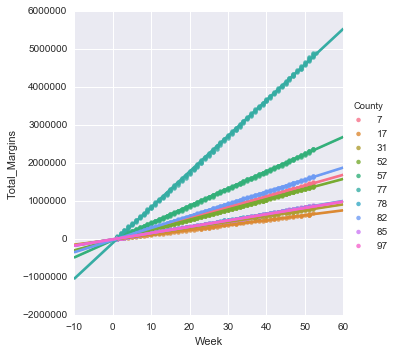

In [38]:
plt.figure(figsize=(10, 10))
sns.lmplot(x='Week',y='Total_Margins',hue='County', data=sales)


In [39]:
sales['Total_Margins'] = sales['Total_Margins'].map(float)

In [40]:
sales.dtypes

Days                  int64
Purchase_Margins     object
Week                  int64
Total_Margins       float64
County                int64
dtype: object

In [41]:
X = sales['Week'].values
Y = sales['Total_Margins'].values

X.shape, Y.shape

((1499,), (1499,))

In [42]:
X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [43]:
print X_train.shape, Y_train.shape
print x_test.shape, y_test.shape

(1049,) (1049,)
(450,) (450,)


In [44]:
regr = LinearRegression()

regr.fit(X_train.reshape(X_train.shape[0],1), y_train.reshape(y_train.shape[0],1))

NameError: name 'y_train' is not defined

In [ ]:
print "Coefficient of: ", regr.coef_
print "Score of: ", regr.score(x_test.reshape(x_test.shape[0],1), y_test.reshape(y_test.shape[0],1))

* Create Dataframes for each of the counties by day and cumulative margins, total volume, bottles sold
* Collapse into one dataframe
* Perform regression on the consolidated dataframe
* Create KNN for invest/not invest in the top ten counties based on how relative they are to the 
* List of datasets for further investigation/polishing

In [ ]:
plt.figure(figsize=(15,15))

plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test.reshape(X_test.shape[0],1), regr.predict(X_test.reshape(X_test.shape[0],1)), color='blue',
         linewidth=3)

plt.xticks()
plt.yticks()

plt.xlabel("Weeks")
plt.ylabel("Projected Profit ($)")
plt.title("2015 Sales in Top 10 Iowa Counties")

plt.xlim(1,53)
plt.ylim(0,5000000)

plt.show()

In [ ]:
count = 0
cdict = {}
for df in [c7,c77,c57,c82,c52,c85,c78,c97,c31,c17]:
    cns = [7,77,57,82,52,85,78,97,31,17]
    X = df['Week'].values
    Y = df['Total_Margins'].values
    
    X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=0.3)
    regr.fit(X_train.reshape(X_train.shape[0],1), Y_train.reshape(Y_train.shape[0],1))
    
    print "For County Number:", cns[count], "Weekly Sale Increase of:", regr.coef_, "Score of", regr.score(x_test.reshape(x_test.shape[0],1), y_test.reshape(y_test.shape[0],1))
    
    cdict[cns[count]] = regr.coef_
    count += 1

In [ ]:
cdict

In [ ]:
cndict = {
        7 : 28564.3,
        17 : 12912,
        31 : 15381.5,
        52 : 26862.5,
        57 : 45258.3,
        77 : 93998.9,
        78 : 16792.9,
        82 : 31751.1,
        85 : 16725.0,
        97 : 16450.9}

counties = cndict.keys()
month_margin = cndict.values()

In [ ]:
df = {'counties' : counties,
'margins' : month_margin}

In [ ]:
df= pd.DataFrame